# データの確認

## 事前設定

In [1]:
# default packages
import logging
import pathlib
import sys
from datetime import datetime
from typing import Generator

In [2]:
# third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
from scipy import io

In [3]:
# my packages
sys.path.append(str(pathlib.Path("..").resolve()))

In [4]:
import feature

In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [7]:
# settings
DATA_DIR = pathlib.Path("../data")
EXAMPLE_SENSOR = DATA_DIR.joinpath("hs_bearing_1/sensor-20130307T015746Z.mat")
EXAMPLE_TACH = DATA_DIR.joinpath("hs_bearing_1/tach-20130307T015746Z.mat")
SENSOR_FILES = DATA_DIR.glob("hs_bearing_*/sensor-*.mat")

In [8]:
SAMPLING_HZ = 97656
SAMPLING_SEC = 6

## データ読み込み

In [9]:
def load_data(filepath: str) -> pd.DataFrame:
    var = io.loadmat(filepath)
    date_val = datetime.strptime(
        pathlib.Path(filepath).stem.split("-")[-1], "%Y%m%dT%H%M%SZ"
    )

    df = pd.DataFrame(var["v"], columns=["vibration"])
    df["date"] = date_val

    return df

In [10]:
def load_some_files(files: Generator) -> pd.DataFrame:
    df = pd.DataFrame()
    for file in sorted(list(files)):
        logger.info(f"load file: {file}")
        df = pd.concat([df, load_data(file)], ignore_index=True)

    return df

In [11]:
df_org = load_some_files(SENSOR_FILES)

INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130307T015746Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130308T023421Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130309T023343Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130310T030102Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130311T030024Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130312T061710Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130313T063404Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130314T065041Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130315T065003Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130316T065643Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130317T065604Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130317T184756Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130318T184715Z.mat
INFO:__main__:load file: ../data/hs_be

## データ表示

In [12]:
display(df_org.head())

,vibration,date
0,-0.414619,2013-03-07 01:57:46
1,0.172490,2013-03-07 01:57:46
2,-0.403777,2013-03-07 01:57:46
3,-0.773542,2013-03-07 01:57:46
4,0.686626,2013-03-07 01:57:46


In [13]:
display(df_org.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29296800 entries, 0 to 29296799
Data columns (total 2 columns):
vibration    float64
date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 447.0 MB


None

In [14]:
display(df_org.describe())

,vibration
count,2.929680e+07
mean,2.291271e-01
std,2.248586e+00
min,-2.165893e+01
25%,-1.218162e+00
50%,2.281493e-01
75%,1.675297e+00
max,2.296917e+01


In [15]:
def plot_per_day(df: pd.DataFrame) -> None:
    fig = plt.figure()

    for date, data in df.groupby(by=["date"]):
        plt.plot(data["vibration"])

    plt.show()
    plt.close(fig)

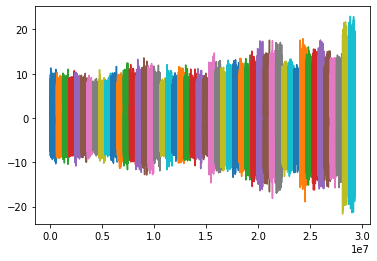

In [16]:
plot_per_day(df_org)

In [17]:
def moving_window_mean(x: np.ndarray, window_size: int, step: int) -> None:
    calc = np.array(
        [
            np.fft.fft(x[idx : idx + window_size])
            for idx in range(0, x.shape[0] - window_size, step)
        ]
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    X, Y = np.meshgrid(range(calc.shape[1]), range(calc.shape[0]))
    ax.plot_surface(X, Y, calc)

    plt.show()
    plt.clf()

/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1760: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1761: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


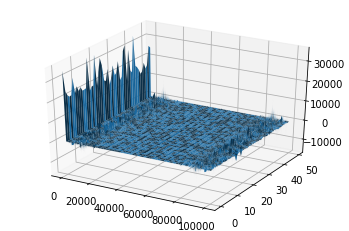

<Figure size 432x288 with 0 Axes>

In [18]:
moving_window_mean(df_org["vibration"].to_numpy(), 100000, SAMPLING_HZ * SAMPLING_SEC)

In [19]:
def pkurtosis(x: np.ndarray, window_size: int, step: int) -> None:
    calc = [
        scipy.signal.spectrogram(
            x[idx : idx + window_size], SAMPLING_HZ, window=("hann"), nperseg=256, scaling="spectrum",
        )
        for idx in range(0, x.shape[0] - window_size, step)
    ]
    
    t = calc[0][1]
    freq = calc[0][0]

    plt.pcolormesh(t, freq, calc[0][2])
    plt.show()
    plt.clf()
    
    calc = np.array([data for _, _, data in calc])
    calc = scipy.stats.kurtosis(calc, axis=2)
    # calc = np.sum(calc, axis=2)

    plt.pcolormesh(freq, range(calc.shape[0]), calc)
    plt.show()
    plt.clf()

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection="3d")
    X, Y = np.meshgrid(freq, range(calc.shape[0]))
    ax.plot_surface(X, Y, calc)

    plt.show()
    plt.clf()

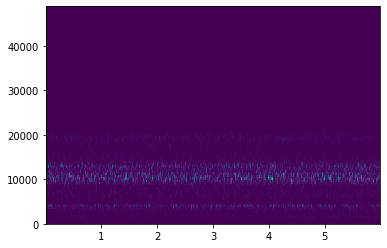

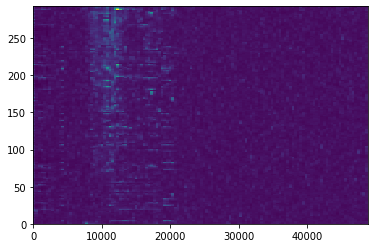

<Figure size 432x288 with 0 Axes>

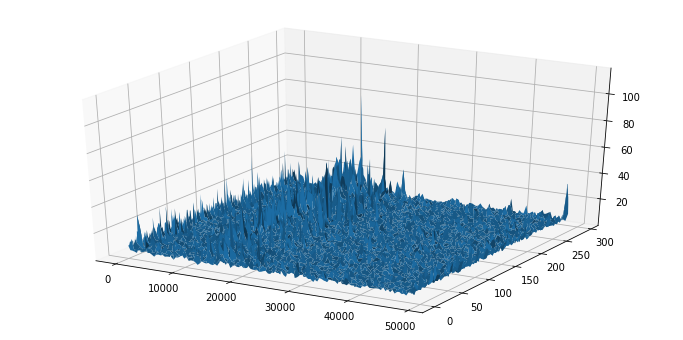

<Figure size 432x288 with 0 Axes>

In [20]:
pkurtosis(
    df_org["vibration"].to_numpy(), SAMPLING_HZ * SAMPLING_SEC, SAMPLING_HZ,
)

In [21]:
def calc_feature(x: np.ndarray) -> None:
    features = feature.calc_all(x[: SAMPLING_HZ * SAMPLING_SEC])

    logger.info(features)

In [22]:
calc_feature(df_org["vibration"].to_numpy())

INFO:__main__:{'Mean': 0.34605184950754025, 'Std': 2.2704814911196487, 'Skewness': 0.0038698541677815723, 'Kurtosis': -0.004387890119418092, 'Peak2Peak': 21.621068, 'CrestFactor': 4.914734629107907, 'ShapeFactor': 1.253516968703474, 'ImpulseFactor': 6.160703254261336, 'MarginFactor': 3.3624508216926126, 'Energy': 3090717.527624413, 'SKMean': 65.9977933738886}


(2615,)
